In [16]:
import pandas as pd
from datetime import datetime, timezone
from scipy import stats
import matplotlib.pyplot as plt
import requests, json
import numpy as np
from collections import defaultdict 
import os

In [2]:
@np.vectorize
def degree2directions(data):
    threasholds = {
        (0, 22.5): "N",
        (22.5, 67.5): "NE",
        (67.5, 112.5): "E",
        (112.5, 157.5): "SE",
        (157.5, 202.5): "S",
        (202.5, 247.5): "SW",
        (247.5, 292.5): "W",
        (292.5, 337.5): "NW",
        (337.5, 360): "N"
    }
    for threashold, direction in threasholds.items():
        if threashold[0] <= data < threashold[1]:
            return direction
    
def read_vazao():
    df_vazao = pd.read_excel('dados/20240507_vazao_enchente.xlsx')
    df_dict = defaultdict(list)
    for i, df_sel in df_vazao.iterrows():
        time = datetime.strptime(f"{df_sel.data}T{df_sel.hora_utc}", "%d/%m/%YT%H:%M:%S")
        df_dict['times'].append(time)
        df_dict['vazao_m3s-1_bt'].append(df_sel['vazao_m3s-1_bt'])
        #df_dict['v_max_ms-1_bt'].append(df_sel['v_max_ms-1_bt'])
        #df_dict['v_media_ms-1_bt'].append(df_sel['v_media_ms-1_bt'])    
    df_vazao = pd.DataFrame(df_dict)
    df_vazao.index = [pd.to_datetime(t).tz_localize('UTC') for t in df_vazao.times]
    df_vazao = df_vazao.drop(columns=['times'])
    return df_vazao
    

In [3]:
def read_level(t0, t1, _id=303, params="water_l1,avg_water_l1,water_l1_ibge,avg_water_l1_ibge,water_l1_dhn,avg_water_l1_dhn"):
    fmt = "%Y-%m-%dT%H:%M:%S"
    tref = datetime.strptime('1970-01-01T00', "%Y-%m-%dT%H").replace(tzinfo=timezone.utc)
    t0, t1 = datetime.strptime(t0, fmt).replace(tzinfo=timezone.utc), \
                datetime.strptime(t1, fmt).replace(tzinfo=timezone.utc)
    print(f'requesting data from {t0} to {t1}')
    url = "https://simcosta.furg.br/api/intrans_data?" \
            f"boiaID={_id}&type=json&time1={(t0 - tref).total_seconds()}&time2={(t1 - tref).total_seconds()}" \
            f"&params={params}"
    response_level = requests.get(url).json()
    parse_response_level = [
        ({
            'timestamp': [r['timestamp']], \
            'YEAR': [r['YEAR']], \
            'MONTH': [r['MONTH']], \
            'DAY': [r['DAY']], \
            'HOUR': [r['HOUR']], \
            'MINUTE': [r['MINUTE']], \
            'SECOND': [r['SECOND']], \
            'water_l1': [r['water_l1']], \
            'water_l1_ibge': [r['water_l1_ibge']], \
            'water_l1_dhn': [r['water_l1_dhn']], \
            'avg_water_l1': [r['avg_water_l1']], \
            'avg_water_l1_ibge': [r['avg_water_l1_ibge']], \
            'avg_water_l1_dhn': [r['avg_water_l1_dhn']]
        }) for r in response_level
    ]
    df_level = pd.concat([pd.DataFrame(p) for p in parse_response_level])
    df_level = df_level.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'SECOND'])
    for i, col in enumerate(df_level.columns):
        if i > 0:
            df_level.loc[:, col] = df_level[col].astype('float')
    df_level.index = pd.to_datetime(df_level['timestamp'])
    df_level = df_level.drop(columns=['timestamp']).dropna()
    return df_level

In [4]:
def read_wind(
    t0, t1, _id=303, 
    params="wind_speed,Avg_Wnd_Sp,wind_direction_n,Avg_Wnd_Dir_N"
):
    fmt = "%Y-%m-%dT%H:%M:%S"
    tref = datetime.strptime('1970-01-01T00', "%Y-%m-%dT%H").replace(tzinfo=timezone.utc)
    t0, t1 = datetime.strptime(t0, fmt).replace(tzinfo=timezone.utc), \
                datetime.strptime(t1, fmt).replace(tzinfo=timezone.utc)
    print(f'requesting data from {t0} to {t1}')
    url = "https://simcosta.furg.br/api/intrans_data?" \
            f"boiaID={_id}&type=json&time1={(t0 - tref).total_seconds()}&time2={(t1 - tref).total_seconds()}" \
            f"&params={params}"
    
    response = requests.get(url).json()
    parse_response = [
        ({
            'timestamp': [r['timestamp']], \
            'YEAR': [r['YEAR']], \
            'MONTH': [r['MONTH']], \
            'DAY': [r['DAY']], \
            'HOUR': [r['HOUR']], \
            'MINUTE': [r['MINUTE']], \
            'SECOND': [r['SECOND']], \
            'wind_speed': [r['wind_speed']], \
            'Avg_Wnd_Sp': [r['Avg_Wnd_Sp']], \
            'wind_direction_N': [r['wind_direction_N']], \
        }) for r in response
    ]
    df_wind = pd.concat([pd.DataFrame(p) for p in parse_response])
    df_wind = df_wind.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'SECOND'])
    for i, col in enumerate(df_wind.columns):
        if i > 0:
            df_wind.loc[:, col] = df_wind[col].astype('float')
    df_wind.index = pd.to_datetime(df_wind['timestamp'])
    df_wind = df_wind.drop(columns=['timestamp']).dropna()
    return df_wind

In [5]:
def get_lags(variable, ref_var):
    laggeds = list()
    for lag in np.arange(-72, 13, 1):
        laggeds.append(pd.DataFrame({f'{str(lag).zfill(4)}':df[variable].shift(lag).values}))

    laggeds = pd.concat(laggeds, axis=1)
    laggeds = laggeds.assign(ref_var=df[ref_var].values).dropna()

    corrs = [
        np.corrcoef(laggeds[str(l)].values, laggeds['ref_var'])[0][1] \
        for i, l in enumerate(list(laggeds.columns)) if l != 'ref_var'
    ]
    return laggeds, corrs

In [20]:
def plot_lag_correlation(ref_var='water_l1_ibge',variables=['wind_speed', 'wind_direction_N']):
    n_axs = len(variables)
    fig, axs = plt.subplots(n_axs, 1, figsize=(30,20), sharey=True, sharex=True)
    for i, variable in enumerate(variables):
        laggeds, corrs = get_lags(variable, ref_var)
        
        xticks = [int(i) for i in list(laggeds.columns) if i != 'ref_var']
    
        for j, c in enumerate(corrs):
            if abs(c) >= 0.3:
                axs[i].scatter(xticks[j], c)
            
        axs[i].plot(xticks, corrs)
        for a in ['x', 'y']:
            axs[i].tick_params(axis=a, labelsize=25)
        axs[i].set_ylabel(f'{variable} correlation',fontsize=35)
        axs[i].set_xlabel('lags',fontsize=35)
        axs[i].set_title(f'{ref_var} x {variable}', fontsize=50)
        axs[i].grid()
    
    plt.tight_layout()
    plt.yticks(np.arange(-1,1+0.2,0.2), fontsize=35)
    plt.xticks(np.arange(-72,0, 2), rotation=45, fontsize=35)
    path_out = "figuras/2024051300/{name}.png"
    os.makedirs(os.path.dirname(path_out.format(name='lag_corr')), exist_ok=True)
    plt.savefig(path_out.format(name='lagg_corr'))
    print(path_out.format(name='speed'))
    plt.show()

In [19]:
def plot_boxplot(df):
    print('01 - *'*10)    
    df[['vazao_m3s-1_bt']].boxplot(figsize=(20,8))
    plt.xticks(rotation=45,fontsize=20);
    path_out = "figuras/2024051300/{name}.png"
    os.makedirs(os.path.dirname(path_out.format(name='vazao')), exist_ok=True)
    plt.savefig(path_out.format(name='vazao'))
    print(path_out.format(name='vazao'))
    plt.show()
    
    print('02 - *'*10)
    df[['wind_direction_N']].boxplot(figsize=(20,8))
    plt.xticks(fontsize=20, rotation=50);
    #[i for i in range(len(drctions))]
    path_out = "figuras/2024051300/{name}.png"
    os.makedirs(os.path.dirname(path_out.format(name='direction')), exist_ok=True)
    plt.savefig(path_out.format(name='direction'))
    print(path_out.format(name='direction'))
    plt.show()

    print('03 - *'*10)
    df[['water_l1', 'water_l1_ibge', 'water_l1_dhn',
         'avg_water_l1_dhn', 'avg_water_l1_ibge']].boxplot(figsize=(20,8))
    #.drop(columns=['wind_direction_N','vazao_m3s-1_bt'])
    plt.xticks(rotation=45,fontsize=20);
    path_out = "figuras/2024051300/{name}.png"
    os.makedirs(os.path.dirname(path_out.format(name='level')), exist_ok=True)
    plt.savefig(path_out.format(name='level'))
    print(path_out.format(name='level'))
    plt.show()
    
    print('04 - *'*10)
    df[['wind_speed', 'Avg_Wnd_Sp']].boxplot(figsize=(20,8))
    #.drop(columns=['wind_direction_N','vazao_m3s-1_bt'])
    plt.xticks(rotation=45,fontsize=20);
    path_out = "figuras/2024051300/{name}.png"
    os.makedirs(os.path.dirname(path_out.format(name='speed')), exist_ok=True)
    plt.savefig(path_out.format(name='speed'))
    print(path_out.format(name='speed'))
    plt.show()

In [14]:
def aggregate_and_convert(df_raw):
    df = df_raw.resample('1h').mean()
    df['class_wind_direction_N'] = degree2directions(df['wind_direction_N'])

    for v in ['wind_speed', 'Avg_Wnd_Sp']:
        df.loc[:, v] = df[v] * 3.6

    for v in ['water_l1', 'water_l1_ibge', 'water_l1_dhn', 
              'avg_water_l1', 'avg_water_l1_ibge', 'avg_water_l1_dhn']:
        df.loc[:, v] = df[v] / 100
    return df

In [9]:
df_vazao = read_vazao()
df_level = read_level("2024-05-01T00:00:00", datetime.now().strftime("%Y-%m-%dT%H:%M:%S"))
df_wind = read_wind("2024-05-01T00:00:00", datetime.now().strftime("%Y-%m-%dT%H:%M:%S"))

requesting data from 2024-05-01 00:00:00+00:00 to 2024-05-13 00:05:07+00:00


/tmp/ipykernel_12152/1533892018.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_level = pd.concat([pd.DataFrame(p) for p in parse_response_level])


requesting data from 2024-05-01 00:00:00+00:00 to 2024-05-13 00:05:14+00:00


/tmp/ipykernel_12152/1720065068.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_wind = pd.concat([pd.DataFrame(p) for p in parse_response])


In [10]:
df_raw = pd.concat([df_wind, df_level, df_vazao], axis=1).astype('float')
df_raw

,wind_speed,Avg_Wnd_Sp,wind_direction_N,water_l1,water_l1_ibge,water_l1_dhn,avg_water_l1,avg_water_l1_ibge,avg_water_l1_dhn,vazao_m3s-1_bt
2024-05-01 00:00:00+00:00,1.4,1.1,56.953,1115.61,137.537,67.344,1115.65,137.577,67.384,NaN
2024-05-01 00:01:00+00:00,NaN,NaN,NaN,1116.94,138.867,68.674,1116.68,138.607,68.414,NaN
2024-05-01 00:02:00+00:00,3.8,2.8,86.953,1118.29,140.217,70.024,1117.31,139.237,69.044,NaN
2024-05-01 00:03:00+00:00,5.0,4.3,89.953,1117.97,139.897,69.704,1117.91,139.837,69.644,NaN
2024-05-01 00:04:00+00:00,5.5,5.2,83.953,1117.45,139.377,69.184,1117.59,139.517,69.324,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-05-13 00:01:00+00:00,10.1,10.6,119.949,1159.34,181.267,111.074,1159.22,181.147,110.954,NaN
2024-05-13 00:02:00+00:00,13.7,11.8,115.949,1159.05,180.977,110.784,1160.38,182.307,112.114,NaN
2024-05-13 00:03:00+00:00,12.0,11.0,119.949,1162.44,184.367,114.174,1160.90,182.827,112.634,NaN
2024-05-13 00:04:00+00:00,11.8,11.6,117.949,1161.25,183.177,112.984,1160.60,182.527,112.334,NaN


In [11]:
df = aggregate_and_convert(df_raw)
df

/home/marten/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in degree2directions (vectorized)
  outputs = ufunc(*inputs)


,wind_speed,Avg_Wnd_Sp,wind_direction_N,water_l1,water_l1_ibge,water_l1_dhn,avg_water_l1,avg_water_l1_ibge,avg_water_l1_dhn,vazao_m3s-1_bt,class_wind_direction_N
2024-05-01 00:00:00+00:00,14.839322,14.735593,161.224186,11.163890,1.383160,0.681230,11.162975,1.382245,0.680315,NaN,S
2024-05-01 01:00:00+00:00,12.178983,12.545085,155.953000,11.231214,1.450484,0.748554,11.231544,1.450814,0.748884,NaN,SE
2024-05-01 02:00:00+00:00,11.772000,11.754000,225.136333,11.239625,1.458895,0.756965,11.239952,1.459222,0.757292,NaN,SW
2024-05-01 03:00:00+00:00,26.040000,25.878000,84.919667,11.232178,1.451448,0.749518,11.234560,1.453830,0.751900,NaN,E
2024-05-01 04:00:00+00:00,25.032000,25.680000,189.203000,11.187603,1.406873,0.704943,11.186510,1.405780,0.703850,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-12 20:00:00+00:00,33.113793,33.151034,95.242103,11.565305,1.784575,1.082645,11.565224,1.784494,1.082564,NaN,E
2024-05-12 21:00:00+00:00,27.516000,27.390000,108.549000,11.554168,1.773438,1.071508,11.553685,1.772955,1.071025,NaN,E
2024-05-12 22:00:00+00:00,36.564000,36.942000,115.515667,11.546335,1.765605,1.063675,11.545930,1.765200,1.063270,NaN,SE
2024-05-12 23:00:00+00:00,39.130169,39.471864,113.457475,11.545808,1.765078,1.063148,11.544990,1.764260,1.062330,NaN,SE


01 - *01 - *01 - *01 - *01 - *01 - *01 - *01 - *01 - *01 - *
figuras/2024051300/vazao.png


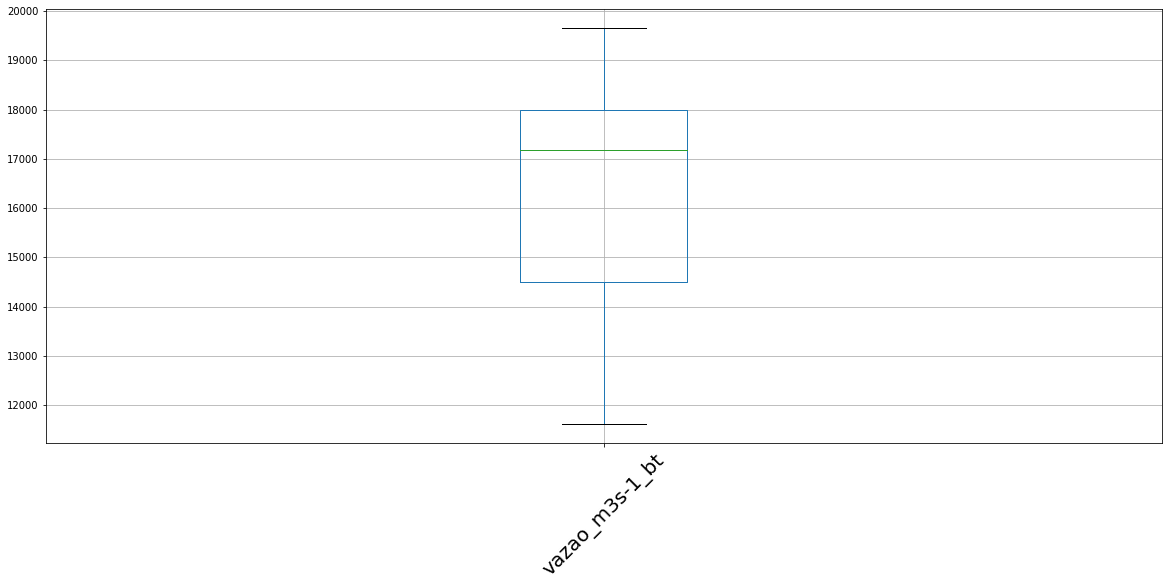

02 - *02 - *02 - *02 - *02 - *02 - *02 - *02 - *02 - *02 - *
figuras/2024051300/direction.png


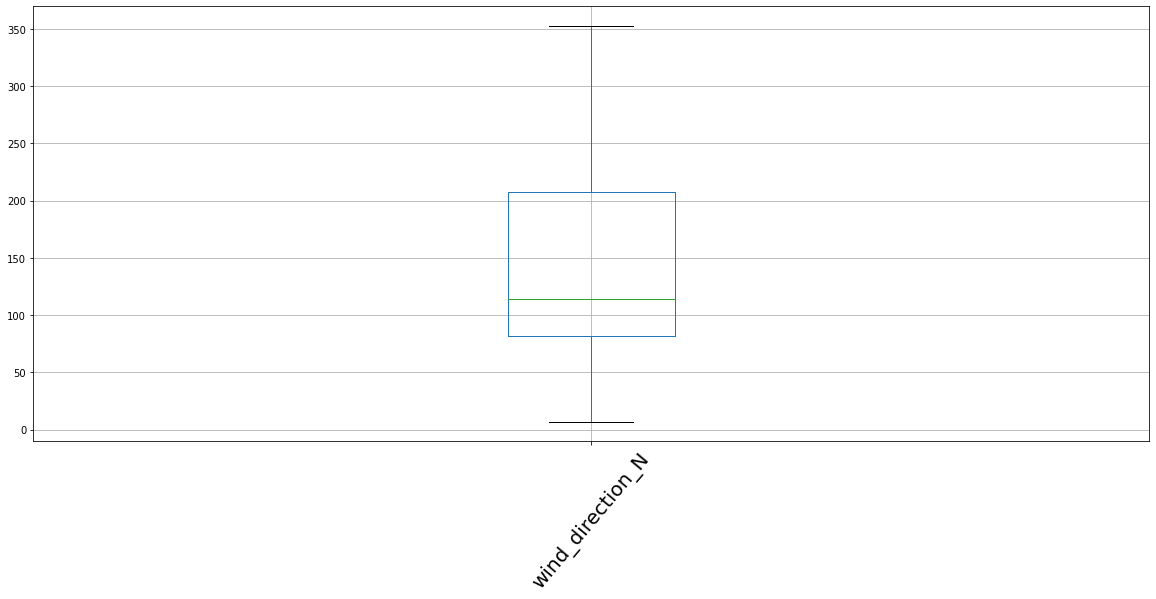

03 - *03 - *03 - *03 - *03 - *03 - *03 - *03 - *03 - *03 - *
figuras/2024051300/level.png


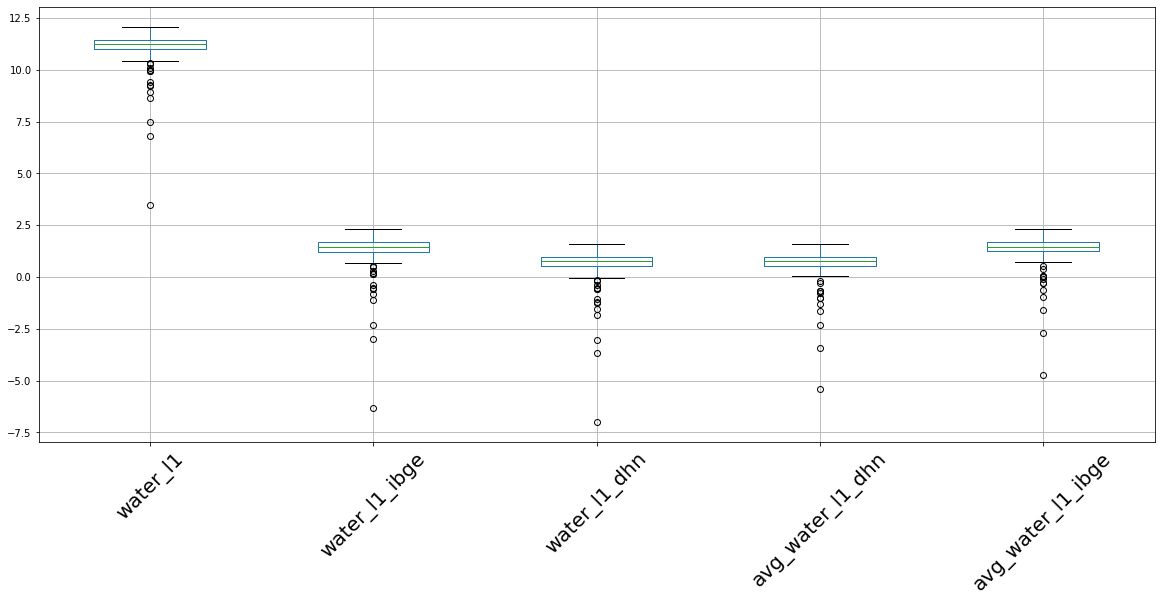

04 - *04 - *04 - *04 - *04 - *04 - *04 - *04 - *04 - *04 - *
figuras/2024051300/speed.png


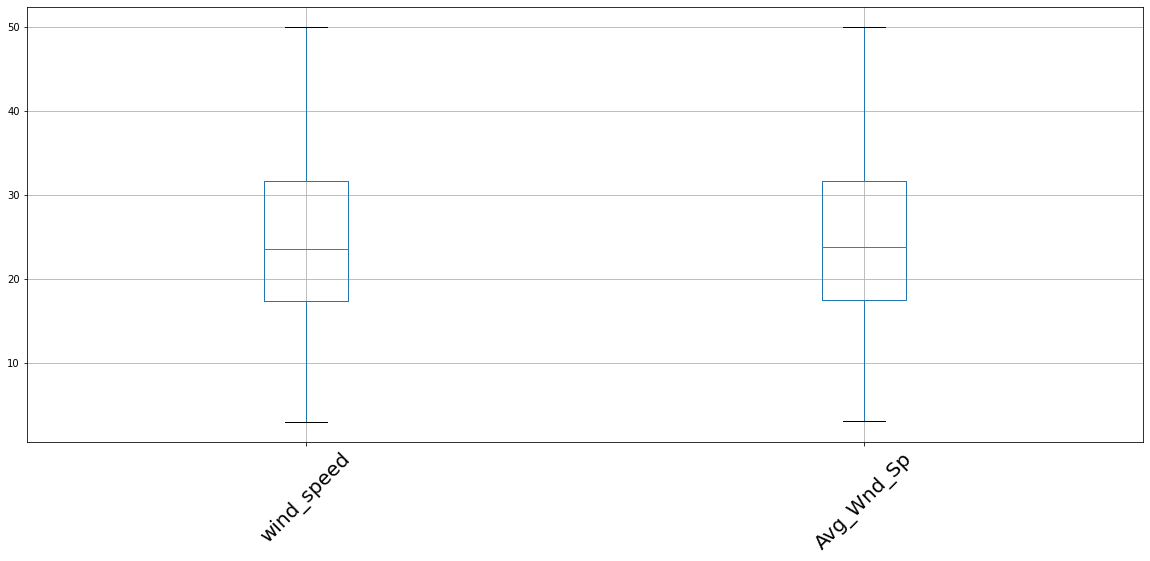

05 - *05 - *05 - *05 - *05 - *05 - *05 - *05 - *05 - *05 - *


/tmp/ipykernel_12152/2786493457.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[:, v][df[v]>50] = 50
/tmp/ipykernel_12152/2786493457.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


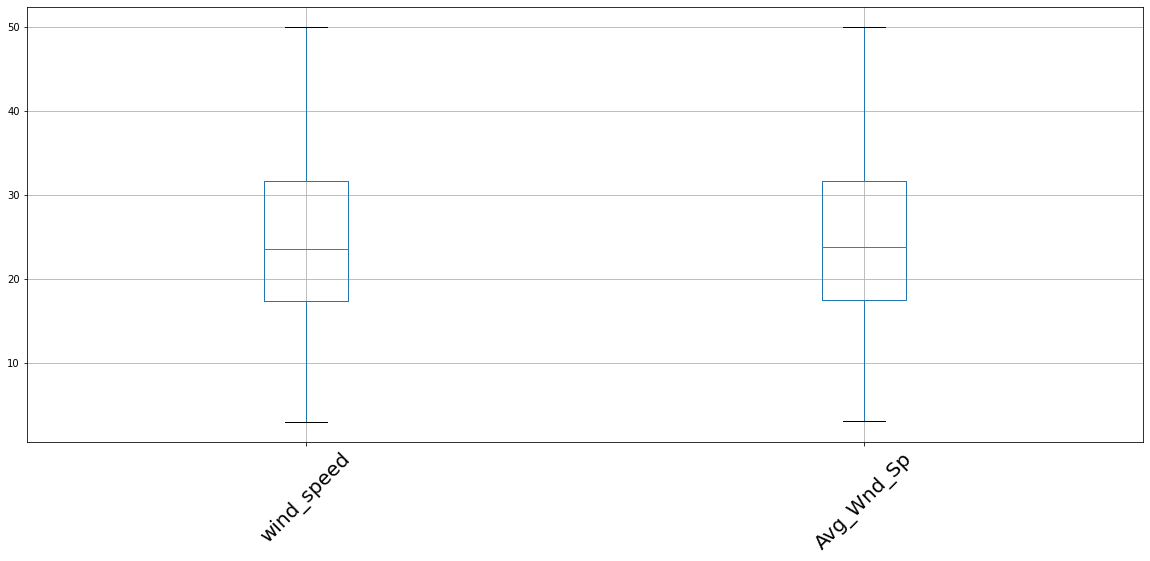

In [21]:
plot_boxplot(df)
for i, v in enumerate(['wind_speed', 'Avg_Wnd_Sp']):
    df.loc[:, v][df[v]>50] = 50

print('05 - *'*10)
df[['wind_speed', 'Avg_Wnd_Sp']].boxplot(figsize=(20,8))
#.drop(columns=['wind_direction_N','vazao_m3s-1_bt'])
plt.xticks(rotation=45,fontsize=20);
plt.show()

figuras/2024051300/speed.png


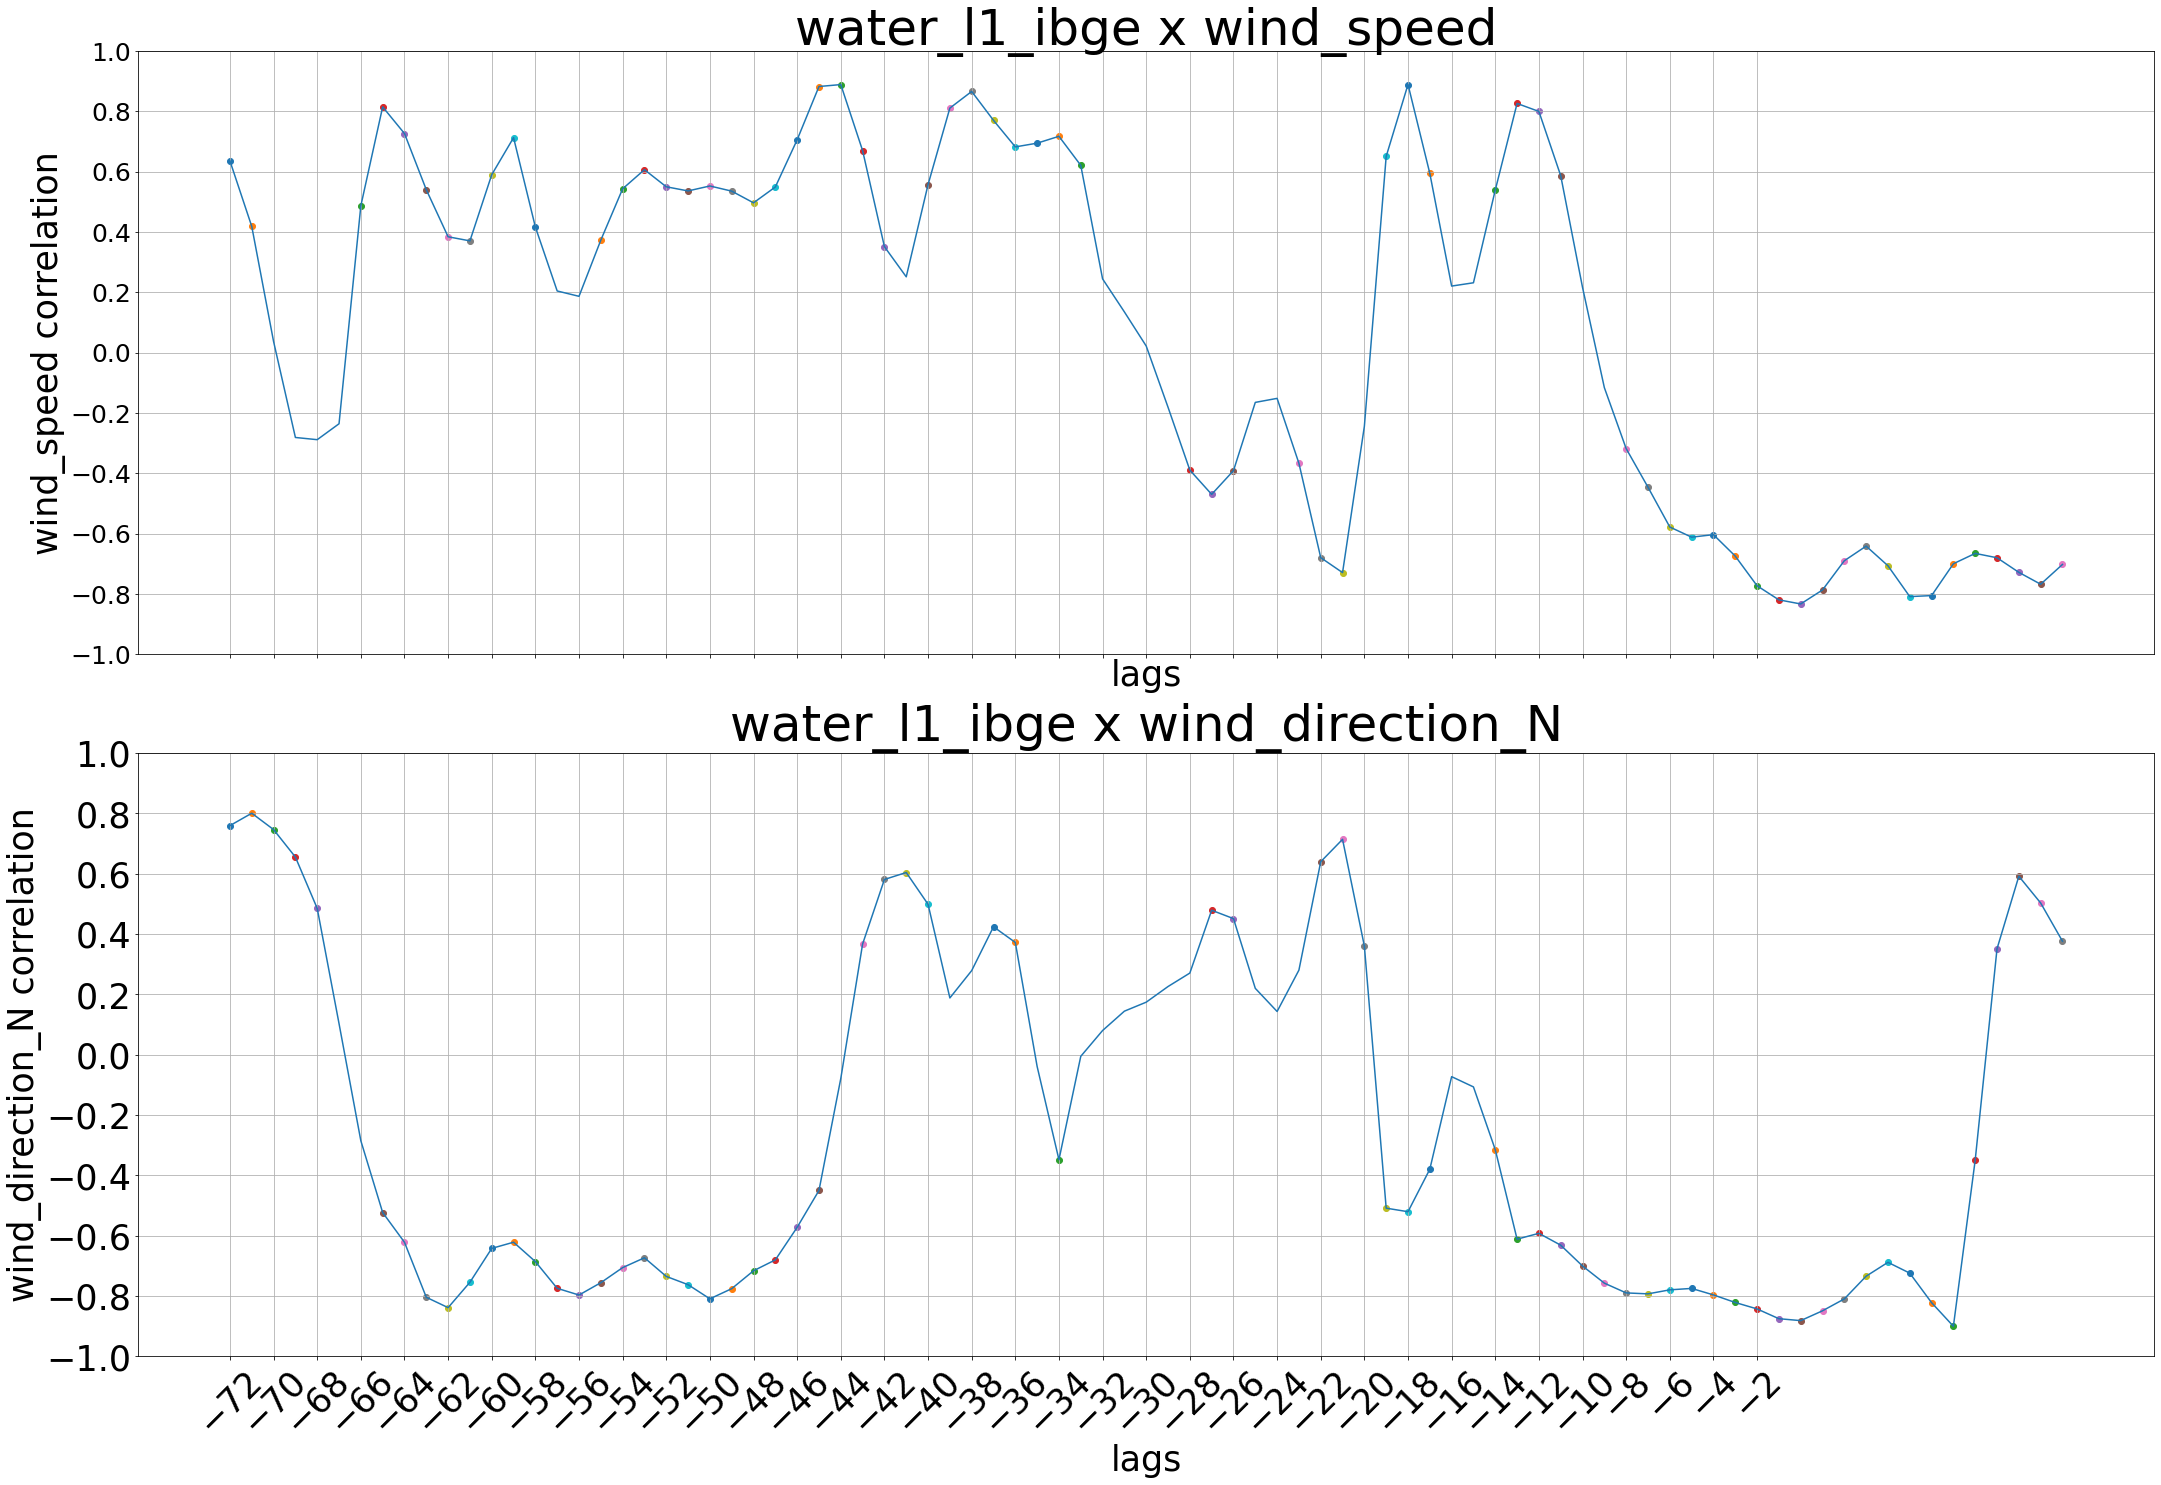

In [22]:
variables = ["wind_speed","wind_direction_N"]
 #"Avg_Wnd_Sp", 
refvars = ["water_l1_ibge"]
#["water_l1", "water_l1_ibge", "water_l1_dhn", "avg_water_l1", "avg_water_l1_ibge", "avg_water_l1_dhn"]
for refvar in refvars:
    plot_lag_correlation(refvar, variables)

In [ ]:
init = '20240511T00'
df_sel = df[df.index >= init]

In [ ]:
# Criando o objeto figura e os eixos
fig, ax = plt.subplots(figsize=(20, 8), dpi=300)

# Plotando o nível do canal e a maré
ax.plot(df_sel['avg_water_l1_ibge'], label='Nível do Canal Boia (m)', color='blue')
# ax.plot(df.index, df['Maré'], label='Maré', color='red')

# Configurando o segundo eixo y para a velocidade do vento
ax2 = ax.twinx()
ax2.plot(df_sel['wind_speed'].shift(-3), label='Velocidade do Vento', color='green')
# Adicionando linhas tracejadas cinzas nos eixos x e y
ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
#ax2.griinit, end = '20240504T00', '20240511T23'd(True, linestyle='--', linewidth=0.5, color='gray')
# Adicionando legendas e rótulos
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.set_title('Dados de Nível do Canal Boia, Velocidade do Vento, Direção do Vento')
ax.set_xlabel('Data/Hora')
ax.set_ylabel('Nível do Canal Boia (m) / Maré')
ax2.set_ylabel('Velocidade do Vento (km/h)')

# Adicionando o texto com a direção do vento
for i, direcao in enumerate(df_sel['class_wind_direction_N'].shift(-3)):
    vazao = df_sel['vazao_m3s-1_bt'].shift(-3)[i]
    if vazao > 0:
        ax2.scatter(df_sel.shift(-3).index[i], 1.5, color='black');
        ax2.text(df_sel.shift(-3).index[i], 1.5, int(vazao), ha='center', fontsize=12, rotation=45);
    ax2.text(df_sel.shift(-3).index[i], df_sel['wind_speed'].shift(-3)[i], direcao, ha='center', fontsize=12, rotation=45);

# Rotacionando os rótulos do eixo x para facilitar a leitura
plt.xticks(rotation=45);

# Mostrando o gráfico
plt.tight_layout()
plt.show()

In [ ]:
# Criando o objeto figura e os eixos
fig, ax = plt.subplots(figsize=(20, 8), dpi=300)

# Plotando o nível do canal e a maré
ax.plot(df_sel['avg_water_l1_ibge'], label='Nível do Canal Boia (m)', color='blue')
# ax.plot(df.index, df['Maré'], label='Maré', color='red')

# Configurando o segundo eixo y para a velocidade do vento
ax2 = ax.twinx()
ax2.plot(df_sel['wind_speed'].shift(-3), label='Velocidade do Vento', color='green')
# Adicionando linhas tracejadas cinzas nos eixos x e y
ax.grid(True, linestyle='--', linewidth=0.5, color='gray')
#ax2.griinit, end = '20240504T00', '20240511T23'd(True, linestyle='--', linewidth=0.5, color='gray')
# Adicionando legendas e rótulos
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.set_title('Dados de Nível do Canal Boia, Velocidade do Vento, Direção do Vento')
ax.set_xlabel('Data/Hora')
ax.set_ylabel('Nível do Canal Boia (m) / Maré')
ax2.set_ylabel('Velocidade do Vento (km/h)')

# Adicionando o texto com a direção do vento
for i, direcao in enumerate(df_sel['class_wind_direction_N'].shift(-3)):
    vazao = df_sel['vazao_m3s-1_bt'].shift(-3)[i]
    if vazao > 0:
        ax2.scatter(df_sel.shift(-3).index[i], 1.5, color='black');
        ax2.text(df_sel.shift(-3).index[i], 1.5, int(vazao), ha='center', fontsize=12, rotation=45);
    ax2.text(df_sel.shift(-3).index[i], df_sel['wind_speed'].shift(-3)[i], direcao, ha='center', fontsize=12, rotation=45);

# Rotacionando os rótulos do eixo x para facilitar a leitura
plt.xticks(rotation=45);

# Mostrando o gráfico
plt.tight_layout()
plt.show()